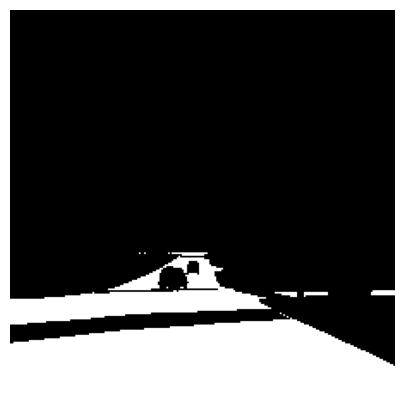

In [5]:
show(trn_ds[1][1])

In [1]:
import os
len(os.listdir('../seg_dataset/images'))

6503

In [ ]:
!pip freeze

: 

In [ ]:
!pip install hydra-core

: 

In [17]:
import cv2
maps_names =  os.listdir('../seg_dataset/maps_roads')
images_names = os.listdir('../seg_dataset/images')
broke_images = []
for image_name in images_names:
    image = cv2.imread(f'../seg_dataset/images/{image_name}', 1) #загружаем изображение
    try:        
        image = cv2.resize(image, (224,224))
    except:
        broke_images.append(image_name)
    

In [9]:
maps_names = set([x[:-3] for x in os.listdir('../seg_dataset/maps_roads')])
images_names = os.listdir('../seg_dataset/images')
for img_name in images_names:
    if img_name[:-3] not in maps_names:
        os.remove(f'../seg_dataset/images/{img_name}')

In [10]:
import pytorch_lightning as pl
from model.model import SegModel
import torch
from nets.U_net_simple import UNet
from nets.SegNet import SegNet
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import CSVLogger

from torch.utils.data import DataLoader 
from dataset.dataset import SegData

In [200]:
net = UNet()
model = SegModel(image_path = '../seg_dataset/images', mask_path = '../seg_dataset/maps_roads',
                 train_ratio = 0.9, num_workers = 8, batch_size = 16, net = net)

In [64]:
checkpoint_callback = ModelCheckpoint(dirpath=r'checkpoints', save_top_k = 3, monitor="Loss_valid", filename="check-{epoch:02d}-{Loss_valid:.2f}-{Accuracy_valid:.2f}")
logger = CSVLogger(r"logs/UNet_simple", name='simple_UNet', flush_logs_every_n_steps = 5)
trainer = pl.Trainer(accelerator = 'cuda', max_epochs=100,  callbacks=[checkpoint_callback], logger = logger, strategy='ddp_notebook',
                     enable_progress_bar = True,  log_every_n_steps = 100, devices=[0,1, 2, 3, 4, 5, 6, 7], # limit_train_batches=3, limit_val_batches=3,
                     deterministic=False, default_root_dir = r'logs/UNet_simple')

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [65]:
trainer.fit(model)

You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Initializing distributed: GLOBAL_RANK: 0, MEMBER: 1/8
You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. 

Sanity Checking DataLoader 0: 100%|██████████| 2/2 [00:00<00:00,  3.23it/s]

/home/user/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:431: It is recommended to use `self.log('Loss_valid', ..., sync_dist=True)` when logging on epoch level in distributed setting to accumulate the metric across devices.
/home/user/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:431: It is recommended to use `self.log('Accuracy_valid', ..., sync_dist=True)` when logging on epoch level in distributed setting to accumulate the metric across devices.


/home/user/.local/lib/python3.8/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=100). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 0: 100%|██████████| 46/46 [00:19<00:00,  2.42it/s, v_num=0, Loss_train_step=0.421, Accuracy_train_step=0.698, Loss_valid_step=0.473, Accuracy_valid_step=0.109, Loss_valid_epoch=0.396, Accuracy_valid_epoch=0.917]

/home/user/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:431: It is recommended to use `self.log('Loss_train', ..., sync_dist=True)` when logging on epoch level in distributed setting to accumulate the metric across devices.
/home/user/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:431: It is recommended to use `self.log('Accuracy_train', ..., sync_dist=True)` when logging on epoch level in distributed setting to accumulate the metric across devices.


Epoch 99: 100%|██████████| 46/46 [00:15<00:00,  2.90it/s, v_num=0, Loss_train_step=0.0607, Accuracy_train_step=0.735, Loss_valid_step=2.030, Accuracy_valid_step=0.117, Loss_valid_epoch=1.500, Accuracy_valid_epoch=0.902, Loss_train_epoch=0.0224, Accuracy_train_epoch=0.988]     

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 46/46 [00:15<00:00,  2.88it/s, v_num=0, Loss_train_step=0.0607, Accuracy_train_step=0.735, Loss_valid_step=2.030, Accuracy_valid_step=0.117, Loss_valid_epoch=1.500, Accuracy_valid_epoch=0.902, Loss_train_epoch=0.0224, Accuracy_train_epoch=0.988]


In [18]:
net = UNet()
model = SegModel(image_path = '../seg_dataset/images', mask_path = '../seg_dataset/maps_roads',
                 train_ratio = 0.9, num_workers = 8, batch_size = 16, net = net)

/home/user/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/user/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [13]:
checkpoint_path = "path/to/checkpoint"
checkpoint = torch.load('logs/UNet_simple/checkpoints/check-epoch=00-Loss_valid=1.17-Accuracy_valid=0.19.ckpt')

/tmp/ipykernel_1502976/798499833.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('logs/UNet_simple/checkpoints/check-epoch=00-Loss_valid=1.17-Acc

In [21]:
checkpoint.keys()

dict_keys(['epoch', 'global_step', 'pytorch-lightning_version', 'state_dict', 'loops', 'callbacks', 'optimizer_states', 'lr_schedulers'])

In [15]:
net = SegNet(1) #UNet()

model = SegModel(image_path = '../seg_dataset/images', mask_path = '../seg_dataset/maps_roads',
                 train_ratio = 0.9, num_workers = 8, batch_size = 16, img_size = 224, net = net)


model.load_state_dict(checkpoint['state_dict'])

/home/user/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/user/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<All keys matched successfully>

In [66]:
torch.save(net.state_dict(), 'simple_unet.pth')

In [16]:
import numpy as np
import torch

In [18]:
val_ds = SegData(image_path = '../seg_dataset/images', mask_path = '../seg_dataset/maps_roads',
                 train_ratio = 0.9, size = 224,  mode = 'test', seed = 1)
batch = next(iter(val_ds))
img, mask = batch 

In [19]:
batched_img = np.expand_dims(np.transpose(img, (2, 0, 1)), axis=0)
batched_mask = np.expand_dims(mask, axis=0)

In [32]:
net.load_state_dict(torch.load('simple_unet.pth'))

/tmp/ipykernel_1290901/3903000480.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load('simple_unet.pth'))


<All keys matched successfully>

In [23]:

#in_img = 
pred = model.net(torch.tensor(batched_img, dtype = torch.float32))

In [24]:
pred.shape

torch.Size([1, 224, 224])

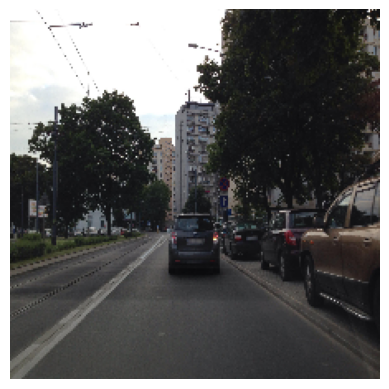

In [21]:
import matplotlib.pyplot as plt
# Визуализация массива
plt.imshow(img, cmap='binary')
plt.axis('off')
plt.show()

In [28]:
pred.squeeze(0).detach().numpy().shape

(224, 224)

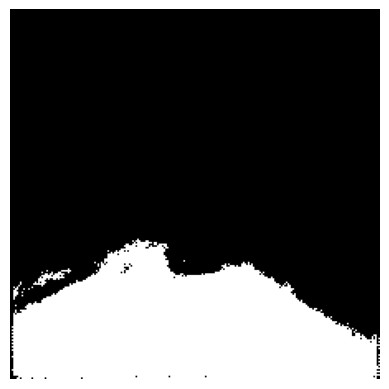

In [29]:
# Замена чисел больше 0.5 на 1, остальные на 0
pred[pred > 0.4] = 255
pred[pred <= 0.4] = 0

# Визуализация массива
plt.imshow(pred.squeeze(0).detach().numpy(), cmap='gray')
plt.axis('off')
plt.show()

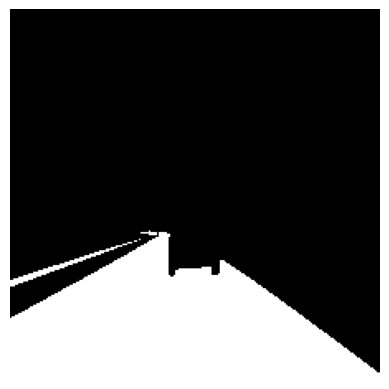

In [30]:
# Визуализация массива
plt.imshow(batched_mask[0], cmap='gray')
plt.axis('off')
plt.show()

In [5]:
from hydra import compose, initialize
from hydra.utils import instantiate
from omegaconf import OmegaConf
with initialize(version_base=None, config_path="configs", job_name="main"):
    cfg = compose(config_name="segnet_train", overrides=["+db=mysql", "+db.user=me"])
print(OmegaConf.to_yaml(cfg))

model:
  _target_: model.model.SegModel
  image_path: ${params.image_path}
  mask_path: ${params.mask_path}
  train_ratio: ${params.train_ratio}
  num_workers: ${params.num_workers}
  batch_size: ${params.batch_size}
  net: ${net}
  img_size: ${params.img_size}
trainer:
  _target_: pytorch_lightning.Trainer
  accelerator: ${params.accelerator}
  max_epochs: ${params.max_epochs}
  logger:
    _target_: pytorch_lightning.loggers.CSVLogger
    save_dir: logs/SegNet
    name: simple_SegNet
    flush_logs_every_n_steps: 5
  strategy: ddp_notebook
  callbacks:
  - ${early_stopping}
  - ${model_checkpoint}
  enable_progress_bar: true
  log_every_n_steps: ${params.log_every_n_steps}
  devices: ${params.devices}
  default_root_dir: logs/SegNet
params:
  train_ratio: 0.9
  num_workers: 8
  batch_size: 16
  seed: 1
  accelerator: cuda
  max_epochs: 1
  checkpoint_path: logs/SegNet/checkpoints
  image_path: ../seg_dataset/images
  mask_path: ../seg_dataset/maps_roads
  log_every_n_steps: 100
  img

/home/user/.local/lib/python3.8/site-packages/hydra/_internal/defaults_list.py:251: UserWarning: In 'segnet_train': Defaults list is missing `_self_`. See https://hydra.cc/docs/1.2/upgrades/1.0_to_1.1/default_composition_order for more information
  warnings.warn(msg, UserWarning)


In [6]:
trainer = instantiate(cfg['trainer']) 
model = instantiate(cfg['model']) 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [7]:
trainer.fit(model)

You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Initializing distributed: GLOBAL_RANK: 0, MEMBER: 1/8
You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. 

Sanity Checking DataLoader 0: 100%|██████████| 2/2 [00:00<00:00,  5.86it/s]

/home/user/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:431: It is recommended to use `self.log('Loss_valid', ..., sync_dist=True)` when logging on epoch level in distributed setting to accumulate the metric across devices.
/home/user/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:431: It is recommended to use `self.log('Accuracy_valid', ..., sync_dist=True)` when logging on epoch level in distributed setting to accumulate the metric across devices.


/home/user/.local/lib/python3.8/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=100). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 0: 100%|██████████| 46/46 [00:17<00:00,  2.67it/s, v_num=7, Loss_train_step=0.205, Accuracy_train_step=0.671, Loss_valid_step=0.299, Accuracy_valid_step=0.102, Loss_valid_epoch=0.375, Accuracy_valid_epoch=0.791]

/home/user/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:431: It is recommended to use `self.log('Loss_train', ..., sync_dist=True)` when logging on epoch level in distributed setting to accumulate the metric across devices.
/home/user/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:431: It is recommended to use `self.log('Accuracy_train', ..., sync_dist=True)` when logging on epoch level in distributed setting to accumulate the metric across devices.


Epoch 0: 100%|██████████| 46/46 [00:17<00:00,  2.67it/s, v_num=7, Loss_train_step=0.205, Accuracy_train_step=0.671, Loss_valid_step=0.299, Accuracy_valid_step=0.102, Loss_valid_epoch=0.375, Accuracy_valid_epoch=0.791, Loss_train_epoch=0.305, Accuracy_train_epoch=0.839]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 46/46 [00:18<00:00,  2.55it/s, v_num=7, Loss_train_step=0.205, Accuracy_train_step=0.671, Loss_valid_step=0.299, Accuracy_valid_step=0.102, Loss_valid_epoch=0.375, Accuracy_valid_epoch=0.791, Loss_train_epoch=0.305, Accuracy_train_epoch=0.839]


In [1]:
from nets.SegNet import SegNet

In [2]:
net = SegNet(num_classes=1)

/home/user/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/user/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [3]:
import torch
rand_img = torch.randn(2, 3,224,224)

In [5]:
net(rand_img)

tensor([[[0.6309, 0.7150, 0.6547,  ..., 0.3535, 0.8406, 0.6122],
         [0.6091, 0.7856, 0.7833,  ..., 0.6298, 0.6546, 0.5491],
         [0.7088, 0.4865, 0.6702,  ..., 0.5647, 0.7841, 0.5654],
         ...,
         [0.6803, 0.5599, 0.8820,  ..., 0.5896, 0.6394, 0.7214],
         [0.6364, 0.7918, 0.8237,  ..., 0.8651, 0.5843, 0.6594],
         [0.5459, 0.5628, 0.6530,  ..., 0.6949, 0.6827, 0.6013]],

        [[0.7093, 0.6525, 0.7685,  ..., 0.6707, 0.5547, 0.6887],
         [0.7167, 0.8016, 0.4452,  ..., 0.8462, 0.7152, 0.5380],
         [0.6970, 0.7426, 0.5937,  ..., 0.6073, 0.6773, 0.6278],
         ...,
         [0.7447, 0.8254, 0.6374,  ..., 0.6012, 0.7595, 0.6444],
         [0.6579, 0.8355, 0.8840,  ..., 0.7543, 0.6890, 0.7005],
         [0.5167, 0.6377, 0.6119,  ..., 0.6058, 0.6932, 0.6645]]],
       grad_fn=<SigmoidBackward0>)

In [ ]:
!sudo apt-get install python-dev
!pip install -U psutil

: 

In [ ]:

!pip install -U git+https://github.com/qubvel-org/segmentation_models.pytorch
!pip install lightning albumentations

: 

In [5]:
import segmentation_models_pytorch as smp

ModuleNotFoundError: No module named 'segmentation_models_pytorch'